# Discover Seattle Airbnb Market - how to invest airbnb as host on Seattle market?

### This project uses --CRISP(Cross industry Process for data mining) Process

### 1. Business understanding 

By downloading the dataset for Seattle airbnb, we want to get a better understanding about seattle airbnb market. how's this business , can we invest an airbnb in seattle?  
Top questions :  

Question 1  How many aiabnb in Seattle now, and how distributed ? 

Question 2  which neighbourhoods are are most popular for host?

Question 3  Which neighbourhood are charging the highest median price?

Question 4  Which types of propety are most in Seattle airbnb market now ? 

Question 5  How price correlate with others factors ?

### 2. Data understanding  
Check data data attributes for calendar.csv , listing.csv , reviews.csv . (EDA analysis)  

In [308]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json #library to handle JSON files
import seaborn as sns
import requests # library to handle requests
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import re
# import k-means from clustering stage
from sklearn.cluster import KMeans
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
from IPython.core.display import HTML
print('Libraries imported.')

Libraries imported.


In [309]:
# Import ML modeling tools
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error


In [310]:
# read datasets 

df_calendar=pd.read_csv("calendar.csv")
df_listing=pd.read_csv("listings.csv")
df_reviews=pd.read_csv("reviews.csv")

### 3. Data Preparing
Data cleaning includes but not limit to data cleaning, dealing with missing value, dummy categorcial variables,web scrape, and scaling.


#### Calendar data preparing

In [311]:
#look at dataset-Calendar
df_calendar.head()


,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [312]:
df_calendar['price'].isnull().value_counts()

False    934542
True     459028
Name: price, dtype: int64

In [313]:
df_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null object
available     1393570 non-null object
price         934542 non-null object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


The calenadar dataset include 1.4 million data.   
Issues found:
listing_id should be numbers not str.  
Date should set to 'datetime'
May dummy available  to 1 or 0 .
Price convert to int. 

In [314]:
df_calendar.available.value_counts()

t    934542
f    459028
Name: available, dtype: int64

In [315]:
#Check null value
df_calendar.isnull().mean()

listing_id    0.00000
date          0.00000
available     0.00000
price         0.32939
dtype: float64

 There are 32% missing value for price. 

In [316]:
df_calendar["price"].value_counts().head(10)

$150.00    36646
$100.00    31755
$75.00     29820
$125.00    27538
$65.00     26415
$90.00     24942
$95.00     24327
$99.00     23629
$85.00     23455
$80.00     19817
Name: price, dtype: int64

In [317]:
# Delete null value for price 
df_calendar=df_calendar.dropna(subset=['price'],axis=0)

#Remove $ and , from price 

df_calendar['price']=df_calendar['price'].replace('[$,]','', regex = True)
df_calendar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 934542 entries, 0 to 1393213
Data columns (total 4 columns):
listing_id    934542 non-null int64
date          934542 non-null object
available     934542 non-null object
price         934542 non-null object
dtypes: int64(1), object(3)
memory usage: 35.6+ MB


In [318]:
#change date datatype to datetime
df_calendar['date'] = pd.to_datetime(df_calendar['date'])
df_calendar['Year']= df_calendar['date'].dt.year
df_calendar['Month']=df_calendar['date'].dt.month
df_calendar['day']=df_calendar['date'].dt.day
#Convert listing_id , price to float, avaiable to boolean
df_calendar['listing_id']=df_calendar['listing_id'].astype(int)
df_calendar['price']=df_calendar['price'].astype(float)


df_calendar.head()


,listing_id,date,available,price,Year,Month,day
0,241032,2016-01-04,t,85.0,2016,1,4
1,241032,2016-01-05,t,85.0,2016,1,5
9,241032,2016-01-13,t,85.0,2016,1,13
10,241032,2016-01-14,t,85.0,2016,1,14
14,241032,2016-01-18,t,85.0,2016,1,18


In [319]:
df_calendar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 934542 entries, 0 to 1393213
Data columns (total 7 columns):
listing_id    934542 non-null int32
date          934542 non-null datetime64[ns]
available     934542 non-null object
price         934542 non-null float64
Year          934542 non-null int64
Month         934542 non-null int64
day           934542 non-null int64
dtypes: datetime64[ns](1), float64(1), int32(1), int64(3), object(1)
memory usage: 53.5+ MB


#### Listings data preparing

In [320]:
#look at dataset
df_listing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498

##### Doing on categorical columns

In [321]:
df_listing_cate=df_listing.select_dtypes(include=['object'])

In [322]:
# Drop some variables we might dont need in further 
df_listing_cate=df_listing_cate.drop(['listing_url', 'name', 'summary', 'experiences_offered','neighborhood_overview',
'notes','transit','thumbnail_url','medium_url', 'picture_url', 'xl_picture_url','host_url','host_name','host_about','host_response_rate','host_thumbnail_url', 'host_picture_url','host_verifications','host_has_profile_pic','street','neighbourhood_cleansed','neighbourhood_group_cleansed',
'market', 'smart_location', 'country_code','country','has_availability', 'calendar_last_scraped', 'first_review','last_review','jurisdiction_names', 'instant_bookable', 'require_guest_profile_picture',
'require_guest_phone_verification', 'description','city','state','requires_license','calendar_updated','last_scraped'],axis=1)

In [323]:
#Sort missing value from high to low 
df_listing_cate.select_dtypes(include=['object']).isnull().mean().sort_values(ascending=False)

monthly_price             0.602672
security_deposit          0.511262
weekly_price              0.473808
cleaning_fee              0.269775
host_acceptance_rate      0.202462
space                     0.149031
host_response_time        0.136983
neighbourhood             0.108958
host_neighbourhood        0.078575
host_location             0.002095
zipcode                   0.001833
host_since                0.000524
host_is_superhost         0.000524
host_identity_verified    0.000524
property_type             0.000262
cancellation_policy       0.000000
extra_people              0.000000
room_type                 0.000000
bed_type                  0.000000
amenities                 0.000000
price                     0.000000
is_location_exact         0.000000
dtype: float64

In [324]:
#Again, by checking missing value above, i have to remove some variables.
df_listing_cate=df_listing_cate.drop(['monthly_price','security_deposit','weekly_price','cleaning_fee'],axis=1)

In [325]:
#Display categorical variables left
df_listing_cate.select_dtypes(include=['object']).columns

Index(['space', 'host_since', 'host_location', 'host_response_time',
       'host_acceptance_rate', 'host_is_superhost', 'host_neighbourhood',
       'host_identity_verified', 'neighbourhood', 'zipcode',
       'is_location_exact', 'property_type', 'room_type', 'bed_type',
       'amenities', 'price', 'extra_people', 'cancellation_policy'],
      dtype='object')

In [326]:
#check value counts
bool_cols = ['host_acceptance_rate', 'host_is_superhost', 'host_identity_verified', 
             'is_location_exact']

for col in bool_cols:
    print('\n')
    print(col)
    print(df_listing_cate[col].value_counts())



host_acceptance_rate
100%    3044
0%         1
Name: host_acceptance_rate, dtype: int64


host_is_superhost
f    3038
t     778
Name: host_is_superhost, dtype: int64


host_identity_verified
t    2997
f     819
Name: host_identity_verified, dtype: int64


is_location_exact
t    3412
f     406
Name: is_location_exact, dtype: int64


In [327]:
#convert f,t to 1,0
df_listing_cate.loc[:,bool_cols]=df_listing_cate[bool_cols].replace({'t': 1, 'f': 0})

In [328]:
df_listing_cate['host_since']=pd.to_datetime(df_listing_cate['host_since'])
df_listing_cate=df_listing_cate.drop(['host_acceptance_rate'],axis=1)
with_dollar=['price','extra_people']
df_listing_cate.loc[:,with_dollar]=df_listing_cate[with_dollar].replace('[$,]','', regex = True)

In [329]:
#change datatype to float
df_listing_cate.loc[:,with_dollar]=df_listing_cate[with_dollar].astype(float)

In [330]:
df_listing_cate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 17 columns):
space                     3249 non-null object
host_since                3816 non-null datetime64[ns]
host_location             3810 non-null object
host_response_time        3295 non-null object
host_is_superhost         3816 non-null object
host_neighbourhood        3518 non-null object
host_identity_verified    3816 non-null object
neighbourhood             3402 non-null object
zipcode                   3811 non-null object
is_location_exact         3818 non-null object
property_type             3817 non-null object
room_type                 3818 non-null object
bed_type                  3818 non-null object
amenities                 3818 non-null object
price                     3818 non-null float64
extra_people              3818 non-null float64
cancellation_policy       3818 non-null object
dtypes: datetime64[ns](1), float64(2), object(14)
memory usage: 507.2+ KB


In [331]:
df_listing_cate.head()

,space,host_since,host_location,host_response_time,host_is_superhost,host_neighbourhood,host_identity_verified,neighbourhood,zipcode,is_location_exact,property_type,room_type,bed_type,amenities,price,extra_people,cancellation_policy
0,Make your self at home in this charming one-be...,2011-08-11,"Seattle, Washington, United States",within a few hours,0,Queen Anne,1,Queen Anne,98119,1,Apartment,Entire home/apt,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",85.0,5.0,moderate
1,"Beautiful, hypoallergenic apartment in an extr...",2013-02-21,"Seattle, Washington, United States",within an hour,1,Queen Anne,1,Queen Anne,98119,1,Apartment,Entire home/apt,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",150.0,0.0,strict
2,"Our house is modern, light and fresh with a wa...",2014-06-12,"Seattle, Washington, United States",within a few hours,0,Queen Anne,1,Queen Anne,98119,1,House,Entire home/apt,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",975.0,25.0,strict
3,NaN,2013-11-06,"Seattle, Washington, United States",NaN,0,Queen Anne,1,Queen Anne,98119,1,Apartment,Entire home/apt,Real Bed,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",100.0,0.0,flexible
4,Cozy family craftman house in beautiful neighb...,2011-11-29,"Seattle, Washington, United States",within an hour,0,Queen Anne,1,Queen Anne,98119,1,House,Entire home/apt,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",450.0,15.0,strict


##### Doing on numercial columns 

In [332]:
df_listing.select_dtypes(include=['int64','float64']).columns

Index(['id', 'scrape_id', 'host_id', 'host_listings_count',
       'host_total_listings_count', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'square_feet', 'guests_included',
       'minimum_nights', 'maximum_nights', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'calculated_host_listings_count',
       'reviews_per_month'],
      dtype='object')

In [333]:
# Create a numercial dataset for analysis 
df_listing_num=df_listing.select_dtypes(include=['int64','float64'])

In [334]:
# Drop some columns which i dont think it's useful
df_listing_num=df_listing_num.drop(['host_id','scrape_id','host_total_listings_count','availability_30',
                'availability_60', 'availability_90', 'availability_365', 
                'review_scores_accuracy', 'review_scores_cleanliness', 
                'review_scores_checkin','review_scores_location','review_scores_communication',
                'review_scores_value', 'license', 'calculated_host_listings_count',
                'reviews_per_month'],axis=1)

In [335]:
df_listing_num.columns

Index(['id', 'host_listings_count', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'square_feet', 'guests_included',
       'minimum_nights', 'maximum_nights', 'number_of_reviews',
       'review_scores_rating'],
      dtype='object')

In [336]:
# Look at any missing value for columns
df_listing_num.select_dtypes(include=['int64','float64']).isnull().mean().sort_values(ascending=False)

square_feet             0.974594
review_scores_rating    0.169460
bathrooms               0.004191
bedrooms                0.001572
host_listings_count     0.000524
beds                    0.000262
number_of_reviews       0.000000
maximum_nights          0.000000
minimum_nights          0.000000
guests_included         0.000000
accommodates            0.000000
longitude               0.000000
latitude                0.000000
id                      0.000000
dtype: float64

In [337]:
# So, it looks i hvae to remove some columns with high pecentage of missing value.
df_listing_num=df_listing_num.drop(['square_feet'],axis=1)

In [338]:
df_listing_num.head()

,id,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,guests_included,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating
0,241032,3.0,47.636289,-122.371025,4,1.0,1.0,1.0,2,1,365,207,95.0
1,953595,6.0,47.639123,-122.365666,4,1.0,1.0,1.0,1,2,90,43,96.0
2,3308979,2.0,47.629724,-122.369483,11,4.5,5.0,7.0,10,4,30,20,97.0
3,7421966,1.0,47.638473,-122.369279,3,1.0,0.0,2.0,1,1,1125,0,NaN
4,278830,2.0,47.632918,-122.372471,6,2.0,3.0,3.0,6,1,1125,38,92.0


In [339]:
# Merge categorcial and numercial variables 
df_new_listings=df_listing_num.merge(df_listing_cate,left_index=True,right_index=True)
df_new_listings.rename(index=str,columns={'id':'listing_id'},inplace=True)
df_new_listings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3818 entries, 0 to 3817
Data columns (total 30 columns):
listing_id                3818 non-null int64
host_listings_count       3816 non-null float64
latitude                  3818 non-null float64
longitude                 3818 non-null float64
accommodates              3818 non-null int64
bathrooms                 3802 non-null float64
bedrooms                  3812 non-null float64
beds                      3817 non-null float64
guests_included           3818 non-null int64
minimum_nights            3818 non-null int64
maximum_nights            3818 non-null int64
number_of_reviews         3818 non-null int64
review_scores_rating      3171 non-null float64
space                     3249 non-null object
host_since                3816 non-null datetime64[ns]
host_location             3810 non-null object
host_response_time        3295 non-null object
host_is_superhost         3816 non-null object
host_neighbourhood        3518 non-null obj

In [340]:
df_new_listings=df_new_listings.drop('price',axis=1)
df=df_new_listings.merge(df_calendar,on="listing_id",how='left')

In [341]:
# This dataset, i may choose these columns for further reseach. 
df.head(400)

,listing_id,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,guests_included,minimum_nights,...,bed_type,amenities,extra_people,cancellation_policy,date,available,price,Year,Month,day
0,241032,3.0,47.636289,-122.371025,4,1.0,1.0,1.0,2,1,...,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",5.0,moderate,2016-01-04,t,85.0,2016.0,1.0,4.0
1,241032,3.0,47.636289,-122.371025,4,1.0,1.0,1.0,2,1,...,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",5.0,moderate,2016-01-05,t,85.0,2016.0,1.0,5.0
2,241032,3.0,47.636289,-122.371025,4,1.0,1.0,1.0,2,1,...,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",5.0,moderate,2016-01-13,t,85.0,2016.0,1.0,13.0
3,241032,3.0,47.636289,-122.371025,4,1.0,1.0,1.0,2,1,...,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",5.0,moderate,2016-01-14,t,85.0,2016.0,1.0,14.0
4,241032,3.0,47.636289,-122.371025,4,1.0,1.0,1.0,2,1,...,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",5.0,moderate,2016-01-18,t,85.0,2016.0,1.0,18.0
5,241032,3.0,47.636289,-122.371025,4,1.0,1.0,1.0,2,1,...,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",5.0,moderate,2016-01-19,t,85.0,2016.0,1.0,19.0
6,241032,3.0,47.636289,-122.371025,4,1.0,1.0,1.0,2,1,...,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",5.0,moderate,2016-01-20,t,85.0,2016.0,1.0,20.0
7,241032,3.0,47.636289,-122.371025,4,1.0,1.0,1.0,2,1,...,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",5.0,moderate,2016-01-24,t,85.0,2016.0,1.0,24.0
8,241032,3.0,47.636289,-122.371025,4,1.0,1.0,1.0,2,1,...,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",5.0,moderate,2016-01-25,t,85.0,2016.0,1.0,25.0
9,241032,3.0,47.636289,-122.371025,4,1.0,1.0,1.0,2,1,...,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",5.0,moderate,2016-01-26,t,85.0,2016.0,1.0,26.0


In [342]:
# look at duplicated value 
df.duplicated().mean()

0.0

#### Web scraping for coordinates and neigbourhood information 

In [343]:
#Load Seattle neighborhood information 
!wget -q -O Seattle_data https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Seattle
print('Data downloaded!')

Data downloaded!


In [344]:
pd.read_html('Seattle_data')[0]

,0,1,2,3,4,5,6,7
0,NaN,Neighborhood name,Within larger district,Annexed[41],Locator map,Street map,Image,Notes
1,1.0,North Seattle,Seattle,Various,NaN,NaN,NaN,North of the Lake Washington Ship Canal[42]
2,2.0,Broadview,North Seattle[42],1954[43],NaN,NaN,NaN,[44]
3,3.0,Bitter Lake,North Seattle[42],1954[43],NaN,NaN,NaN,[45]
4,4.0,North Beach / Blue Ridge,North Seattle[42],"1940,[43] 1954[43]",NaN,NaN,NaN,[46]
5,5.0,Crown Hill,North Seattle[42],"1907,[47] 1952,[43] 1954[43]",NaN,NaN,NaN,[48]
6,6.0,Greenwood,North Seattle[42],"1891,[43] 1954[43]",NaN,NaN,NaN,[49]
7,7.0,Northgate,North Seattle[42],various 1891-1954[43],NaN,NaN,NaN,[50]
8,8.0,Haller Lake,Northgate[50],1954[43],NaN,NaN,NaN,[51]
9,9.0,Pinehurst,Northgate[50],1953[43],NaN,NaN,NaN,[52]


In [345]:
# Clean and format data
Seattle_data=pd.read_html('Seattle_data')[0]
Seattle_data.columns=Seattle_data.iloc[0]
Seattle_data=Seattle_data.drop(Seattle_data.index[0])
Seattle_data.drop(['Annexed[41]','Locator map','Street map','Image','Notes'],axis=1,inplace=True)
Seattle_data['Neighborhood name']
Seattle_list=(Seattle_data['Neighborhood name']).tolist()
Seattle_list
pattern = r'\([^)]*\)'
re.sub(pattern,"",str(Seattle_list))

"['North Seattle', 'Broadview', 'Bitter Lake', 'North Beach / Blue Ridge', 'Crown Hill', 'Greenwood', 'Northgate', 'Haller Lake', 'Pinehurst', 'North College Park ', 'Maple Leaf', 'Lake City', 'Cedar Park', 'Matthews Beach', 'Meadowbrook', 'Olympic Hills', 'Victory Heights', 'Wedgwood', 'View Ridge', 'Sand Point', 'Roosevelt', 'Ravenna', 'Bryant', 'Windermere', 'Hawthorne Hills', 'Laurelhurst', 'University District ', 'University Village', 'Wallingford', 'Northlake', 'Green Lake', 'Fremont', 'Phinney Ridge', 'Ballard', 'West Woodland', 'Whittier Heights', 'Adams', 'Sunset Hill', 'Loyal Heights', 'Central Seattle', 'Magnolia', 'Lawton Park', 'Briarcliff', 'Southeast Magnolia', 'Interbay', 'Queen Anne', 'North Queen Anne', 'East Queen Anne', 'Lower Queen Anne', 'West Queen Anne', 'Capitol Hill', 'Portage Bay[95] / Roanoke', 'Broadway', 'Pike-Pine Corridor / Pike/Pine[97][98][99]', 'Montlake', 'Stevens', 'Interlaken', 'Madison Valley', 'Renton Hill', 'Madison Park', 'Broadmoor', 'Lake Uni

Seattle all neighbouhoods list

'North Seattle', 'Broadview', 'Bitter Lake', 'North Beach / Blue Ridge', 'Crown Hill', 'Greenwood', 'Northgate', 'Haller Lake', 'Pinehurst', 'North College Park ', 'Maple Leaf', 'Lake City', 'Cedar Park', 'Matthews Beach', 'Meadowbrook', 'Olympic Hills', 'Victory Heights', 'Wedgwood', 'View Ridge', 'Sand Point', 'Roosevelt', 'Ravenna', 'Bryant', 'Windermere', 'Hawthorne Hills', 'Laurelhurst', 'University District ', 'University Village', 'Wallingford', 'Northlake', 'Green Lake', 'Fremont', 'Phinney Ridge', 'Ballard', 'West Woodland', 'Whittier Heights', 'Adams', 'Sunset Hill', 'Loyal Heights', 'Central Seattle', 'Magnolia', 'Lawton Park', 'Briarcliff', 'Southeast Magnolia', 'Interbay', 'Queen Anne', 'North Queen Anne', 'East Queen Anne', 'Lower Queen Anne', 'West Queen Anne', 'Capitol Hill', 'Portage Bay','Roanoke', 'Broadway', 'Pike-Pine Corridor', 'Montlake', 'Stevens', 'Interlaken', 'Madison Valley', 'Renton Hill', 'Madison Park', 'Broadmoor', 'Lake Union', 'South Lake Union, Seattle', 'Cascade, Seattle', 'Westlake', 'Eastlake', 'Downtown', 'Denny Triangle', 'Belltown', 'Pike-Market', 'Central Business District', 'First Hill', 'Pioneer Square', 'International District ', 'Yesler Terrace', 'Central Waterfront', 'West Edge', 'Central Area','Central District ', 'Mann', 'Minor', 'Cherry Hill', 'Squire Park', 'Atlantic', 'Judkins Park', 'Madrona', 'Madrona Valley', 'Harrison','Denny-Blaine', 'Washington Park', 'Leschi', 'South End', 'Rainier Valley', 'Mount Baker', 'Columbia City', 'Hillman City', 'Brighton', 'Dunlap','Othello', 'Rainier Beach', 'Atlantic City Beach', 'Rainier View','Lakeridge', 'Seward Park', 'Lakewood', 'Beacon Hill', 'North Beacon Hill', 'Mid Beacon Hill ', 'Holly Park','NewHolly', 'South Beacon Hill','Van Asselt', 'Industrial District', 'SoDo', 'Harbor Island', 'Georgetown', 'South Park', 'West Seattle', 'Alki Point', 'North Admiral','Admiral District', 'Junction','West Seattle Junction',  'Alaska Junction', 'Seaview','Mee-Kwa-Mooks', 'Fairmount Park', 'Genesee', 'Gatewood', 'Fauntleroy', 'Arbor Heights', 'Delridge', 'North Delridge', 'Pigeon Point', 'Riverview', 'Highland Park', 'South Delridge', 'Roxhill', 'High Point'

In [346]:
#Create a
aa=['North Seattle', 'Broadview', 'Bitter Lake', 'North Beach','Blue Ridge', 'Crown Hill', 'Greenwood', 'Northgate', 'Haller Lake', 'Pinehurst', 'North College Park', 'Maple Leaf', 'Lake City', 'Cedar Park', 'Matthews Beach', 'Meadowbrook', 'Olympic Hills', 'Victory Heights', 'Wedgwood', 'View Ridge', 'Sand Point', 'Roosevelt', 'Ravenna', 'Bryant', 'Windermere', 'Hawthorne Hills', 'Laurelhurst', 'University District', 'University Village', 'Wallingford', 'Northlake', 'Green Lake', 'Fremont', 'Phinney Ridge', 'Ballard', 'West Woodland', 'Whittier Heights', 'Adams', 'Sunset Hill', 'Loyal Heights', 'Central Seattle', 'Magnolia', 'Lawton Park', 'Briarcliff', 'Southeast Magnolia', 'Interbay', 'Queen Anne', 'North Queen Anne', 'East Queen Anne', 'Lower Queen Anne', 'West Queen Anne', 'Capitol Hill', 'Portage Bay','Roanoke', 'Broadway', 'Pike-Pine Corridor', 'Montlake', 'Stevens', 'Interlaken', 'Madison Valley', 'Renton Hill', 'Madison Park', 'Broadmoor', 'Lake Union', 'South Lake Union', 'Cascade, Seattle', 'Westlake', 'Eastlake', 'Downtown', 'Denny Triangle', 'Belltown', 'Pike-Market', 'Central Business District', 'First Hill', 'Pioneer Square', 'International District', 'Yesler Terrace', 'Central Waterfront', 'West Edge', 'Central Area','Central District ', 'Mann', 'Minor', 'Cherry Hill', 'Squire Park', 'Atlantic', 'Judkins Park', 'Madrona', 'Madrona Valley', 'Harrison','Denny-Blaine', 'Washington Park', 'Leschi', 'South End', 'Rainier Valley', 'Mount Baker', 'Columbia City', 'Hillman City', 'Brighton', 'Dunlap','Othello', 'Rainier Beach', 'Atlantic City Beach', 'Rainier View','Lakeridge', 'Seward Park', 'Lakewood', 'Beacon Hill', 'North Beacon Hill', 'Mid Beacon Hill ', 'Holly Park','NewHolly', 'South Beacon Hill','Van Asselt', 'Industrial District', 'SoDo', 'Harbor Island', 'Georgetown', 'South Park', 'West Seattle', 'Alki Point', 'North Admiral','Admiral District', 'Junction','West Seattle Junction', 'Alaska Junction', 'Seaview','Mee-Kwa-Mooks', 'Fairmount Park', 'Genesee', 'Gatewood', 'Fauntleroy', 'Arbor Heights', 'Delridge', 'North Delridge', 'Pigeon Point', 'Riverview', 'Highland Park', 'South Delridge', 'Roxhill', 'High Point']

In [347]:
# choose only seattle dataframe
df.dropna(subset=["host_location"])
df=df[df['host_location'].str.contains('Seattle',na=False)]
df['host_neighbourhood']=df.host_neighbourhood.replace({"Alki":"Alki Point","The Junction":"Junction","Pike Place Market":"Pike-Market","Mathews Beach":"Matthews Beach",
                  "North Beach/Blue Ridge":"North Beach","Wedgewood":"Wedgwood","Harrison/Denny-Blaine":"Harrison"})

In [348]:
# Delete abnormal neighbourhoods
df['host_neighbourhood']=df.host_neighbourhood[df[(df.host_neighbourhood!='Baldwin Hills')&(df.host_neighbourhood!='Central San Pedro')&(df.host_neighbourhood!='Licton Springs')&(df.host_neighbourhood!='Manhattan Beach')
            &(df.host_neighbourhood!='Kaanapali')&(df.host_neighbourhood!='Kauaʻi')].index]


In [349]:
#creat array for Seattle neigbouhood 
set(aa)


{'Adams',
 'Admiral District',
 'Alaska Junction',
 'Alki Point',
 'Arbor Heights',
 'Atlantic',
 'Atlantic City Beach',
 'Ballard',
 'Beacon Hill',
 'Belltown',
 'Bitter Lake',
 'Blue Ridge',
 'Briarcliff',
 'Brighton',
 'Broadmoor',
 'Broadview',
 'Broadway',
 'Bryant',
 'Capitol Hill',
 'Cascade, Seattle',
 'Cedar Park',
 'Central Area',
 'Central Business District',
 'Central District ',
 'Central Seattle',
 'Central Waterfront',
 'Cherry Hill',
 'Columbia City',
 'Crown Hill',
 'Delridge',
 'Denny Triangle',
 'Denny-Blaine',
 'Downtown',
 'Dunlap',
 'East Queen Anne',
 'Eastlake',
 'Fairmount Park',
 'Fauntleroy',
 'First Hill',
 'Fremont',
 'Gatewood',
 'Genesee',
 'Georgetown',
 'Green Lake',
 'Greenwood',
 'Haller Lake',
 'Harbor Island',
 'Harrison',
 'Hawthorne Hills',
 'High Point',
 'Highland Park',
 'Hillman City',
 'Holly Park',
 'Industrial District',
 'Interbay',
 'Interlaken',
 'International District',
 'Judkins Park',
 'Junction',
 'Lake City',
 'Lake Union',
 'Laker

In [350]:

set(df.host_neighbourhood)

{'Alki Point',
 'Arbor Heights',
 'Atlantic',
 'Ballard',
 'Belltown',
 'Bitter Lake',
 'Brighton',
 'Broadview',
 'Broadway',
 'Bryant',
 'Capitol Hill',
 'Cedar Park',
 'Central Business District',
 'Columbia City',
 'Crown Hill',
 'Dunlap',
 'Eastlake',
 'Fauntleroy',
 'First Hill',
 'Fremont',
 'Gatewood',
 'Genesee',
 'Georgetown',
 'Green Lake',
 'Greenwood',
 'Haller Lake',
 'Harrison',
 'High Point',
 'Highland Park',
 'Holly Park',
 'Industrial District',
 'Interbay',
 'International District',
 'Junction',
 'Laurelhurst',
 'Leschi',
 'Lower Queen Anne',
 'Madison Park',
 'Madrona',
 'Magnolia',
 'Maple Leaf',
 'Matthews Beach',
 'Meadowbrook',
 'Minor',
 'Montlake',
 'Mount Baker',
 'North Admiral',
 'North Beach',
 'North Beacon Hill',
 'North College Park',
 'North Delridge',
 'Olympic Hills',
 'Phinney Ridge',
 'Pike-Market',
 'Pioneer Square',
 'Portage Bay',
 'Queen Anne',
 'Rainier Beach',
 'Ravenna',
 'Riverview',
 'Roosevelt',
 'Roxhill',
 'Seaview',
 'Seward Park',
 

In [351]:
# To look at any no-matched value for host_neighbourhood
list(set(df.host_neighbourhood) - set(aa))

[nan]

In [352]:
df.host_location.value_counts()

Seattle, Washington, United States                                    795250
Seattle                                                                 1622
Montezuma,Costas Rica  and Seattle Wasington, United States              831
Seattle, Washington                                                      809
Seattle and Bellingham, Washington, United States                        669
Seattle WA                                                               424
Seattle, WA                                                              403
Seattle, Washington and London, England                                  365
I live between Princeville Kauai and Seattle Wa, homes both places       326
Vashon Island, Seattle, WA                                               314
Seattle, WA, United States                                               277
USA (Seattle)/Germany (Lake Constance)                                   223
Seattle WA and Portland OR                                               222

In [353]:
#chcek null value for host_neighbourhood
df.host_neighbourhood.isnull().value_counts()

False    738291
True      63992
Name: host_neighbourhood, dtype: int64

In [354]:
# creat a dataset for null value of neigbourhood
df_null_neig=df[df.host_neighbourhood.isnull()]
df_null_neig.head()

,listing_id,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,guests_included,minimum_nights,...,bed_type,amenities,extra_people,cancellation_policy,date,available,price,Year,Month,day
3160,3883392,1.0,47.635546,-122.373171,4,1.0,2.0,3.0,1,3,...,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",0.0,moderate,2016-01-04,t,195.0,2016.0,1.0,4.0
3161,3883392,1.0,47.635546,-122.373171,4,1.0,2.0,3.0,1,3,...,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",0.0,moderate,2016-01-05,t,195.0,2016.0,1.0,5.0
3162,3883392,1.0,47.635546,-122.373171,4,1.0,2.0,3.0,1,3,...,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",0.0,moderate,2016-01-06,t,195.0,2016.0,1.0,6.0
3163,3883392,1.0,47.635546,-122.373171,4,1.0,2.0,3.0,1,3,...,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",0.0,moderate,2016-01-07,t,195.0,2016.0,1.0,7.0
3164,3883392,1.0,47.635546,-122.373171,4,1.0,2.0,3.0,1,3,...,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",0.0,moderate,2016-01-08,t,195.0,2016.0,1.0,8.0


In [355]:
# Display unqiue record for location(combined latitude and lonfitude )

df_null_neig=df_null_neig.assign(lat_long=[*zip(df_null_neig.latitude,df_null_neig.longitude)])

print(df_null_neig.latitude.nunique())
sss=(df_null_neig.lat_long).unique()

262


In [ ]:
match coodinates with neigbourhood for those hosts without neigbourhood information.  

In [538]:
#Print address details for all missing neigbourhoods.
address = 'Seattle'
geolocator = Nominatim(user_agent="to_explorer")
address_list = []
for id in sss:
    location = geolocator.reverse(id)
    address_list.append(location.address)
    

In [357]:
# I used Excel to re-format address_list. and add coodinate to dateframe
read_part1=pd.read_csv('get_seattle_info_new2.csv')
read_part1['lat_long']=sss
read_part1

,host_neighbourhood,city,Unnamed: 2,Unnamed: 3,lat_long
0,Interbay,Seattle,NaN,NaN,"(47.6355455115124, -122.37317075183506)"
1,Interbay,Seattle,NaN,NaN,"(47.63564979343857, -122.37289282480928)"
2,Interbay,Seattle,NaN,NaN,"(47.638297567073266, -122.37377871072084)"
3,Sunset Hill,Seattle,NaN,NaN,"(47.669327174719676, -122.39259356469371)"
4,Ballard,Seattle,NaN,NaN,"(47.6706623229397, -122.37866592236747)"
5,Seaview,Seattle,NaN,NaN,"(47.66968184535222, -122.3909884706122)"
6,Ballard,Seattle,NaN,NaN,"(47.675757643265115, -122.37879830487678)"
7,Seaview,Seattle,NaN,NaN,"(47.66934442551612, -122.38653914653787)"
8,Phinney Ridge,Seattle,NaN,NaN,"(47.66501670356925, -122.36470709008397)"
9,Phinney Ridge,Seattle,NaN,NaN,"(47.66520903071561, -122.36245654108221)"


In [358]:
df_null_neig=df_null_neig.merge(read_part1,on="lat_long",how='left')

In [359]:
# To check the is the neighouhood name correct? 
address = 'Seattle'
geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.reverse((47.65012433429003, -122.34328293185615))
print(location.address)

3523, Stone Way North, Eastlake, Fremont, Seattle, King County, Washington, 98103, United States of America


In [360]:
df.columns

Index(['listing_id', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'guests_included',
       'minimum_nights', 'maximum_nights', 'number_of_reviews',
       'review_scores_rating', 'space', 'host_since', 'host_location',
       'host_response_time', 'host_is_superhost', 'host_neighbourhood',
       'host_identity_verified', 'neighbourhood', 'zipcode',
       'is_location_exact', 'property_type', 'room_type', 'bed_type',
       'amenities', 'extra_people', 'cancellation_policy', 'date', 'available',
       'price', 'Year', 'Month', 'day'],
      dtype='object')

In [361]:
df_null_neig.columns

Index(['listing_id', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'guests_included',
       'minimum_nights', 'maximum_nights', 'number_of_reviews',
       'review_scores_rating', 'space', 'host_since', 'host_location',
       'host_response_time', 'host_is_superhost', 'host_neighbourhood_x',
       'host_identity_verified', 'neighbourhood', 'zipcode',
       'is_location_exact', 'property_type', 'room_type', 'bed_type',
       'amenities', 'extra_people', 'cancellation_policy', 'date', 'available',
       'price', 'Year', 'Month', 'day', 'lat_long', 'host_neighbourhood_y',
       'city', 'Unnamed: 2', 'Unnamed: 3'],
      dtype='object')

In [362]:
#Rename host_neighbourhood_y to host_neighbourhood
df_null_neig=df_null_neig.rename(columns={"host_neighbourhood_y":"host_neighbourhood"})
                    

In [363]:
# df_all dataset contain non-missing and fillful missing value for host_neigbourhood
frames = [df,df_null_neig]
df_all = pd.concat(frames)

df_all.drop_duplicates(keep=False,inplace=True) 
df_all=df_all[['bathrooms', 'bed_type','beds', 'bedrooms','cancellation_policy','date','extra_people','host_neighbourhood','host_response_time', 'host_since',
                   'number_of_reviews','accommodates', 'maximum_nights','zipcode','price','property_type', 'listing_id','latitude', 'room_type','host_is_superhost','review_scores_rating']]
df_all.info()

C:\Users\liuyi\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


<class 'pandas.core.frame.DataFrame'>
Int64Index: 866275 entries, 0 to 63991
Data columns (total 21 columns):
bathrooms               862334 non-null float64
bed_type                866275 non-null object
beds                    865910 non-null float64
bedrooms                864978 non-null float64
cancellation_policy     866275 non-null object
date                    866185 non-null datetime64[ns]
extra_people            866275 non-null float64
host_neighbourhood      802283 non-null object
host_response_time      766057 non-null object
host_since              866275 non-null datetime64[ns]
number_of_reviews       866275 non-null int64
accommodates            866275 non-null int64
maximum_nights          866275 non-null int64
zipcode                 864974 non-null object
price                   866185 non-null float64
property_type           865966 non-null object
listing_id              866275 non-null int64
latitude                866275 non-null float64
room_type               86

### reviews data preparing

In [364]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
listing_id       84849 non-null int64
id               84849 non-null int64
date             84849 non-null object
reviewer_id      84849 non-null int64
reviewer_name    84849 non-null object
comments         84831 non-null object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


In [365]:
df_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [366]:
# put all three datasets together
df_all_review=df_all.merge(df_reviews,on="listing_id",how='left')
df_all_review['zipcode']=df_all_review.zipcode.astype(float)
df_all_review['price']=df_all_review.price.astype(float)

In [367]:
#df_all_review.drop_duplicates(subset='listing_id', keep="last")
df_unique=df_all_review.drop_duplicates(subset='listing_id', keep="first")


###  Question 1  How many aiabnb in Seattle now, and how distributed ? 

In [368]:
print('The total number of airbnb in Seattle are {}'.format(df_unique.latitude.nunique()))

The total number of airbnb in Seattle are 3288


In [369]:
df_unique.host_neighbourhood.value_counts()

Capitol Hill                 376
Belltown                     203
Ballard                      193
Minor                        175
Queen Anne                   168
Fremont                      131
Wallingford                  119
Ravenna                       96
North Beacon Hill             93
Stevens                       75
Greenwood                     73
University District           68
Lower Queen Anne              64
First Hill                    63
Columbia City                 57
Green Lake                    51
Central Business District     48
North Admiral                 47
Magnolia                      45
Phinney Ridge                 45
Atlantic                      42
Eastlake                      41
Mount Baker                   41
Maple Leaf                    38
Leschi                        37
Madrona                       35
Junction                      32
Pike-Market                   29
Genesee                       28
Roosevelt                     27
          

### which neighbourhoods are are most popular for host?

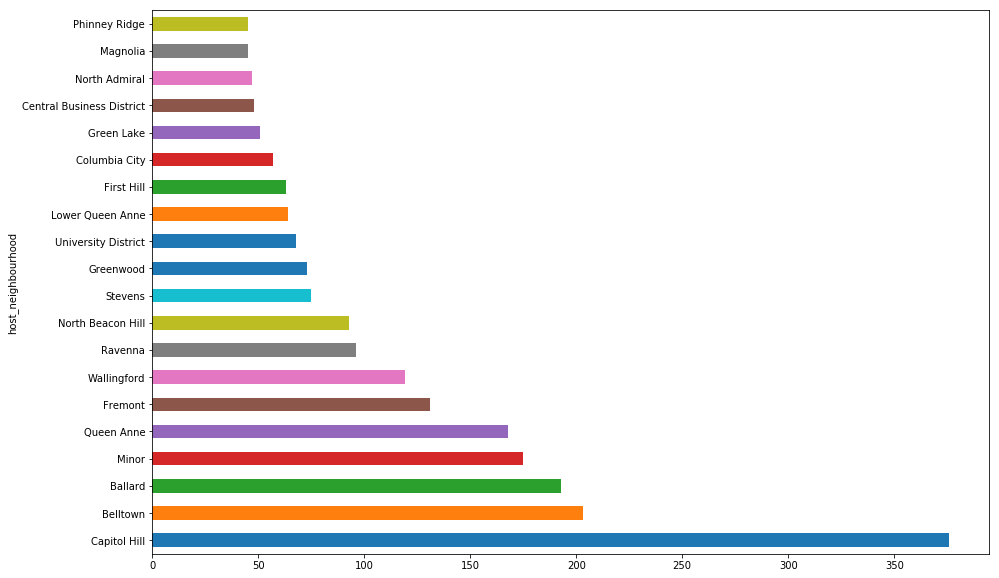

In [370]:
# make a plot for how many host in each of neighbourhood 
df_unique.groupby(['host_neighbourhood']).listing_id.nunique().sort_values(ascending=False)[:20].plot(kind='barh',figsize=(15,10))

Capital hill, Belltown, Ballard, Minor, Queen anne are five top popular neigbouhoods for aiabnb location. 

### Which neighbourhood are charging the highest median price?

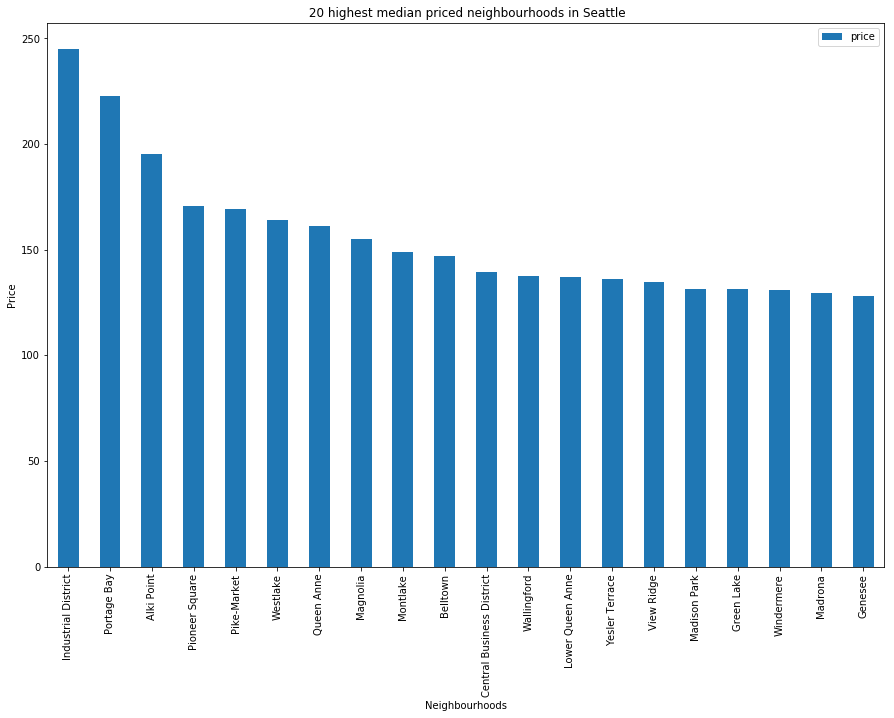

In [371]:
# Display median price per night for each neigbourhood
bottom20_n = df_unique.groupby('host_neighbourhood')[['price']].mean().sort_values("price",ascending=False).head(20)
bottom20_n.plot(kind="bar",figsize=(15,10))
plt.ylabel('Price')
plt.xlabel('Neighbourhoods')

plt.title(" 20 highest median priced neighbourhoods in Seattle");


#df_listing_id.groupby(['host_neighbourhood']).price.mean()

Above plot shows the median price for each neihbouhood , so we can see industrial distrcit , alki point , pioneer sqaure, pike-market, and belltown are 5 most expersive areas in seattle. 

In [372]:
# Used for test funtions above
#df_all[df_all['host_neighbourhood']=='Portage Bay'].price.median()

In [373]:
# Used for test fuction 
#df_all[df_all['host_neighbourhood']=='Industrial District'].price.value_counts()

### Which type of propety are most in Seattle airbnb market now ? 

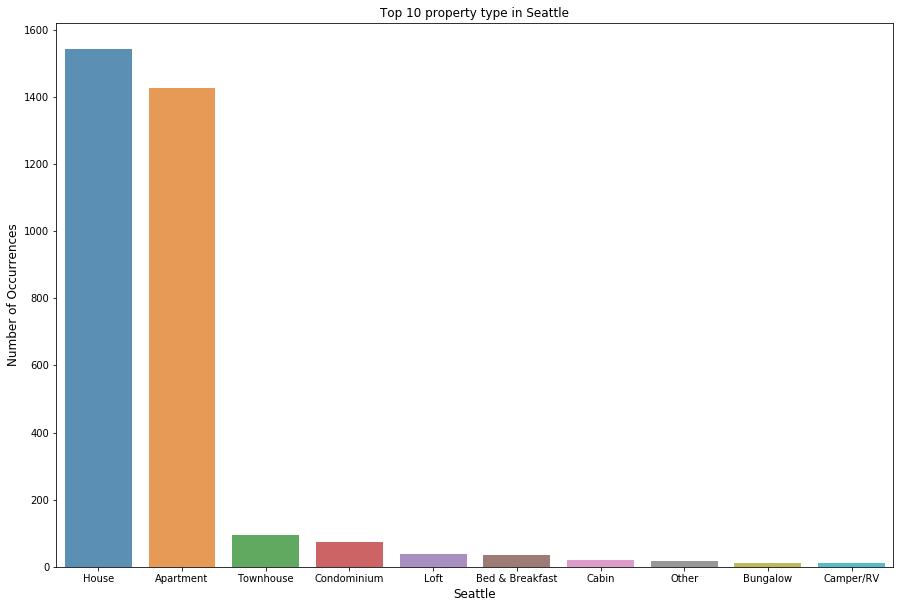

In [374]:
#I want to see which property_type is most popular 
room_type_count  = df_unique['property_type'].value_counts()[0:10,]
room_type_count[0:10,]
plt.figure(figsize=(15,10))
sns.barplot( room_type_count.index, room_type_count.values, alpha=0.8)
plt.title('Top 10 property type in Seattle')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Seattle', fontsize=12)
plt.show()

House and aparment are most popular property type in Seattle used for airbnb. 

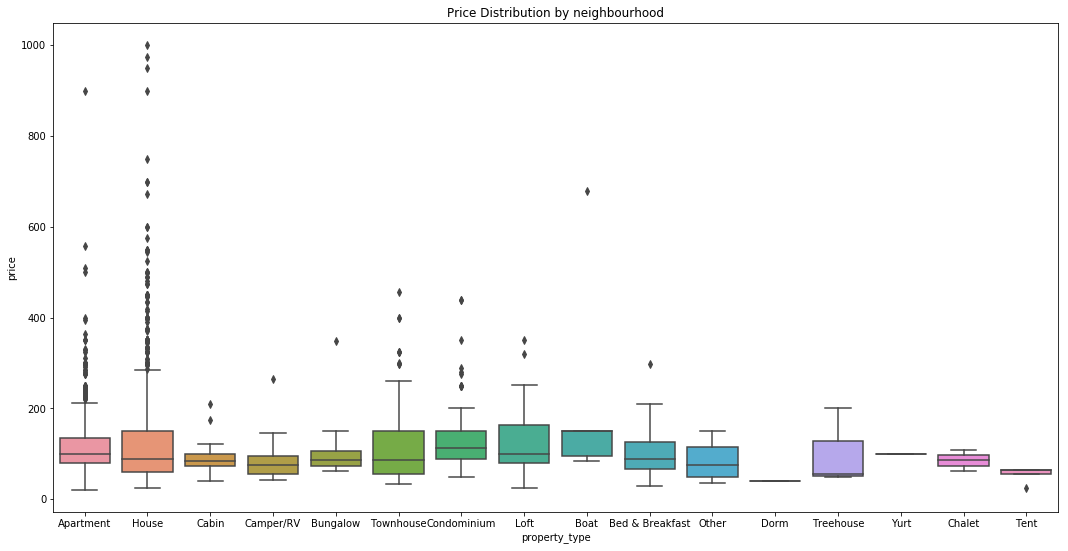

In [375]:
# Price by neigbourhood as we may want to see something more for price distribution 
plt.figure(figsize=(18,9))
sns.boxplot(x='property_type', y='price', data=df_unique)
plt.title('Price Distribution by neighbourhood')
plt.show()

So, we can see the median price for different type of property are similar. But the price range for house and apartments are wider.

### How price correlate with others factors ?

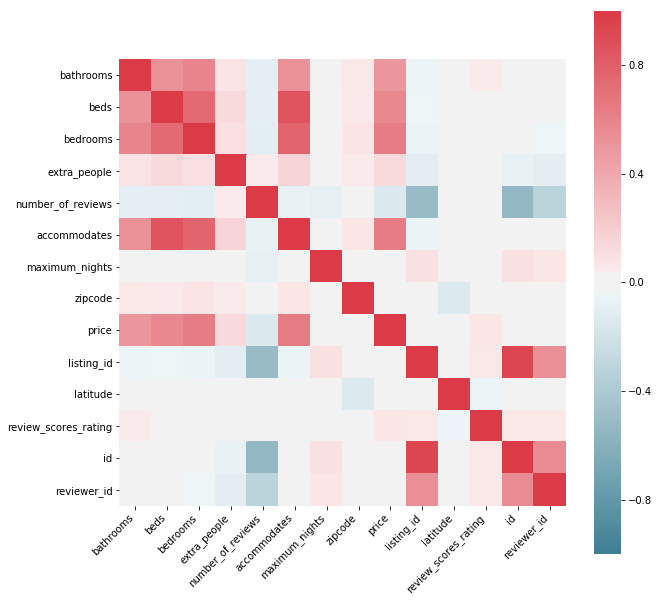

In [376]:
# Display corrlation martix 
corr = df_unique.corr()
fig, ax = plt.subplots(figsize=(10,10))  
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

From the corrlation matrix , we can see price is corrlation with number of bedrooms,bathrooms and review_scores_rating ,which means more bedroom,extra people, and bathroom ,higher review rating and accept more people, the price will be higher. 


C:\Users\liuyi\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


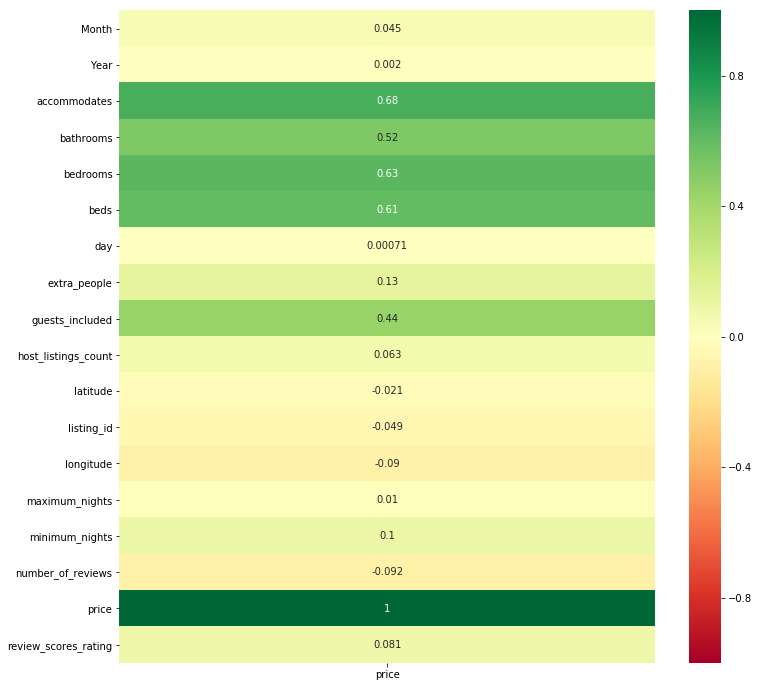

In [377]:
# I want to look at the corrlation martix for price , i choose to use more columns at this time 
frames = [df,df_null_neig]
df_all_one = pd.concat(frames)
df_all_one.drop(['Unnamed: 2','Unnamed: 3'],axis=1,inplace=True)
plt.figure(figsize=(12,12))

sns.heatmap(pd.DataFrame(df_all_one.corr()['price']), annot = True, cmap="RdYlGn",vmin=-1, vmax=1).sort=True

### 4.  Data Modeling 

In [531]:
frames = [df,df_null_neig]
df_all_model = pd.concat(frames)
df_all_model=df_all_model[['bathrooms','host_is_superhost','property_type','guests_included','beds','extra_people','bedrooms','accommodates','price','cancellation_policy','room_type']]
df_all_model.drop_duplicates(keep=False,inplace=True)

df_all_model.isnull().sum()

C:\Users\liuyi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


bathrooms               0
host_is_superhost       0
property_type           0
guests_included         0
beds                    0
extra_people            0
bedrooms                2
accommodates            0
price                  68
cancellation_policy     0
room_type               0
dtype: int64

In [533]:
df_all_model=df_all_model.fillna(df_all_model.mean())

In [534]:
def get_other_dums(df, lst):
    for col in lst:
        try:
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_')], axis=1)
        except:
            continue
    return df

In [535]:
get_other_dums_lst = [ 'room_type', 'room_type','bed_type','property_type','cancellation_policy']
df_all_dums = get_other_dums(df_all_model, get_other_dums_lst)


In [536]:

X = df_all_dums.drop(columns = ['price'], axis=1)
y = df_all_dums['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

ln_reg = LinearRegression(normalize=True)
ln_reg.fit(X_train, y_train) #Fit

#Predict using your model
y_test_preds = ln_reg.predict(X_test)
y_train_preds = ln_reg.predict(X_train)

#Score using your model
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)
pd.DataFrame({'variable': X.columns, 'estimate': ln_reg.coef_})

,variable,estimate
0,bathrooms,6.264335e+01
1,host_is_superhost,2.670685e+01
2,guests_included,7.805568e-01
3,beds,1.215894e+01
4,extra_people,-1.573871e+00
5,bedrooms,1.587140e+01
6,accommodates,8.004642e-01
7,room_type_Entire home/apt,6.376702e+13
8,room_type_Private room,6.376702e+13
9,room_type_Shared room,6.376702e+13


### 5. Evaluation 

In [537]:

print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_score, test_score))

The rsquared on the training data was 0.5848552969146159.  The rsquared on the test data was 0.588109501789088.
